In [ ]:
import torch
from torch.autograd.functional import hessian

In [ ]:
def pow_reducer(x):
  return x.pow(3).sum() # x^3 -> f'(xi) = 3xi^2, f''(xi, xj) = 6xi if xi == xj else 0, f''(1, 1) = 6

# shape [3, 3] or ([3], [3], [3]) -> [3, 3, 3, 3] or (3, 3) x [3, 3]
inputs = torch.tensor([[1, 0, 0], [0, 1, 0], [0, 0, 1]], dtype=torch.float)
# hessian for one input treats first dim as number of inputs, then calculates pairwise hessian on the remaining dimensions
# first two dim: (i, j) second two dim: (xi, xj)
# e.g. hessian[0][0] = f''(inputs[0], inputs[0])
print(hessian(pow_reducer, inputs).shape)
hessian(pow_reducer, inputs)

torch.Size([3, 3, 3, 3])


tensor([[[[6., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],

         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],

         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]]],


        [[[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],

         [[0., 0., 0.],
          [0., 6., 0.],
          [0., 0., 0.]],

         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]]],


        [[[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],

         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],

         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 6.]]]])

In [ ]:
def pow_adder_reducer(x, y):
  # 2x^2y^2
  # f'(xi) = 4xiy^2
  # f''(xi, xj) = 4y^2 if xi == xj else 0
  # f'(yi) = 4x^2yi
  # f''(yi, yj) = 4x^2 if yi == yj else 0
  # f''(xi, yj) = 8xiyj
  return (2 * x.pow(2) * y.pow(2)).sum()

# shape ([2], [2]) -> (2, 2) x [2, 2]
# (4 * [3, 4]^2 = [36, 64], 8 * 1 * 2 = 16, same, 4 * 1^2 = 4)
inputs = (torch.tensor([1, 2], dtype=torch.float), torch.tensor([3, 4], dtype=torch.float))
# hessian for multiple inputs calculates hessian for each pair of inputs
for i in range(2):
  for j in range(2):
    print(i, j, hessian(pow_adder_reducer, inputs)[i][j].shape, hessian(pow_adder_reducer, inputs)[i][j])

0 0 torch.Size([2, 2]) tensor([[36.,  0.],
        [ 0., 64.]])
0 1 torch.Size([2, 2]) tensor([[24.,  0.],
        [ 0., 64.]])
1 0 torch.Size([2, 2]) tensor([[24.,  0.],
        [ 0., 64.]])
1 1 torch.Size([2, 2]) tensor([[ 4.,  0.],
        [ 0., 16.]])


In [ ]:
def pow_adder_reducer2(x, y, z):
  return (2 * x.pow(2) * y.pow(2) * z.pow(2)).sum() # 2x^2y^2z^2

inputs = (torch.tensor([1], dtype=torch.float), torch.tensor([2], dtype=torch.float), torch.tensor([3], dtype=torch.float))
for i in range(3):
  for j in range(3):
      print(i, j, hessian(pow_adder_reducer2, inputs)[i][j].shape, hessian(pow_adder_reducer2, inputs)[i][j])

0 0 torch.Size([1, 1]) tensor([[144.]])
0 1 torch.Size([1, 1]) tensor([[144.]])
0 2 torch.Size([1, 1]) tensor([[96.]])
1 0 torch.Size([1, 1]) tensor([[144.]])
1 1 torch.Size([1, 1]) tensor([[36.]])
1 2 torch.Size([1, 1]) tensor([[48.]])
2 0 torch.Size([1, 1]) tensor([[96.]])
2 1 torch.Size([1, 1]) tensor([[48.]])
2 2 torch.Size([1, 1]) tensor([[16.]])


In [ ]:
# [] hessian matrix in colab - "the dog walks away" - word level - visualization
# [] for one doc, do outer(xi, xj) * hessian(xi, xj) - sum up both levels
# - layer-wise prop codebased - for transformers

### Self Interaction Sample

In [ ]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 55.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 36.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 68.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 56.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 25.9 MB/s eta 0:00:00


In [ ]:
import torch
from torch.autograd.functional import hessian
from transformers import BertTokenizer, BertModel
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

input_ids = tokenizer.encode("the dog walks away", add_special_tokens=True)
input_tensor = torch.tensor(input_ids).unsqueeze(0) # shape [1, seq_length]
seq_length = input_tensor.shape[1]
print('input_tensor', input_tensor)
print('input decoded', tokenizer.decode(input_tensor[0]))

with torch.no_grad():
  outputs = model(input_tensor)
  embeddings = outputs['last_hidden_state'] # shape [1, seq_length, hidden_size]
  print('embeddings shape', embeddings.shape)

input_tensor tensor([[ 101, 1996, 3899, 7365, 2185,  102]])
input decoded [CLS] the dog walks away [SEP]
embeddings shape torch.Size([1, 6, 768])


In [ ]:
def dot_product(xi, xj): # shape [hidden_size], [hidden_size] -> 1
  return torch.dot(xi, xj)

result_matrix = np.zeros((seq_length, seq_length))
for i in range(seq_length):
  for j in range(seq_length):
    xi = embeddings[0, i, :] # shape [hidden_size]
    xj = embeddings[0, j, :] # shape [hidden_size]

    outer_product = torch.outer(xi, xj) # shape [hidden_size, hidden_size]
    hessian_val = hessian(dot_product, (xi, xj)) # shape (2, 2) x (hidden_size, hidden_size)
    hessian_val_ij = hessian_val[0][1] # get one res from (xi, xj) pair
    assert(torch.isclose(hessian_val[0][1].sum(), hessian_val[1][0].sum()))
    res_val = outer_product * hessian_val_ij # shape [hidden_size, hidden_size]

    # Sum up all dimensions of (xi, xj)
    result_matrix[i, j] = res_val.sum().item()

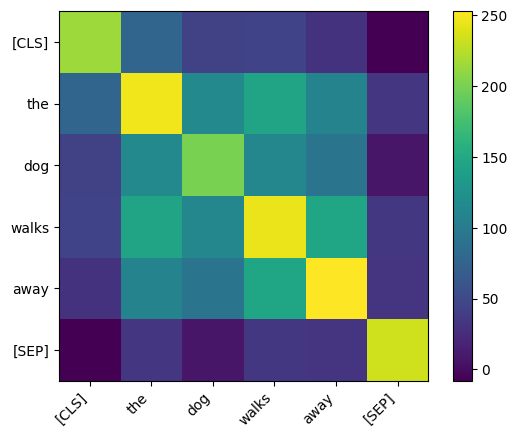

In [ ]:
token_labels = tokenizer.convert_ids_to_tokens(input_ids)
plt.imshow(result_matrix)
plt.colorbar()
plt.xticks(range(len(token_labels)), token_labels, rotation=45, ha="right")
plt.yticks(range(len(token_labels)), token_labels)
plt.show()

### Cross-Interaction Sample

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

x_ids = tokenizer.encode("everyone finds a job including me!", add_special_tokens=True)
y_ids = tokenizer.encode("everyone gets a job", add_special_tokens=True)
x_tensor = torch.tensor(x_ids).unsqueeze(0) # shape [1, x_seq_length]
y_tensor = torch.tensor(y_ids).unsqueeze(0) # shape [1, y_seq_length]
x_seq_length = x_tensor.shape[1]
y_seq_length = y_tensor.shape[1]
print('x decoded', tokenizer.decode(x_tensor[0]))
print('y decoded', tokenizer.decode(y_tensor[0]))

with torch.no_grad():
  x_outputs = model(x_tensor)
  x_embeddings = x_outputs['last_hidden_state'] # shape [1, x_seq_length, hidden_size]
  print('x embeddings shape', x_embeddings.shape)
  y_outputs = model(y_tensor)
  y_embeddings = y_outputs['last_hidden_state'] # shape [1, y_seq_length, hidden_size]
  print('y embedding shape', y_embeddings.shape)

x decoded [CLS] everyone finds a job including me! [SEP]
y decoded [CLS] everyone gets a job [SEP]
x embeddings shape torch.Size([1, 9, 768])
y embedding shape torch.Size([1, 6, 768])


In [ ]:
def dot_product(xi, yj): # shape [hidden_size], [hidden_size] -> 1
  return torch.dot(xi, yj)

result_matrix = torch.zeros((x_seq_length, y_seq_length))
for i in range(x_seq_length):
  for j in range(y_seq_length):
    xi = x_embeddings[0, i, :] # shape [hidden_size]
    yj = y_embeddings[0, j, :] # shape [hidden_size]

    outer_product = torch.outer(xi, yj) # shape [hidden_size, hidden_size]
    hessian_val = hessian(dot_product, (xi, yj)) # shape (2, 2) x (hidden_size, hidden_size)
    hessian_val_ij = hessian_val[0][1] # get one res from (xi, yj) pair
    assert(torch.isclose(hessian_val[0][1].sum(), hessian_val[1][0].sum()))
    res_val = outer_product * hessian_val_ij # shape [hidden_size, hidden_size]

    # Sum up all dimensions of (xi, xj)
    result_matrix[i, j] = res_val.sum().item()

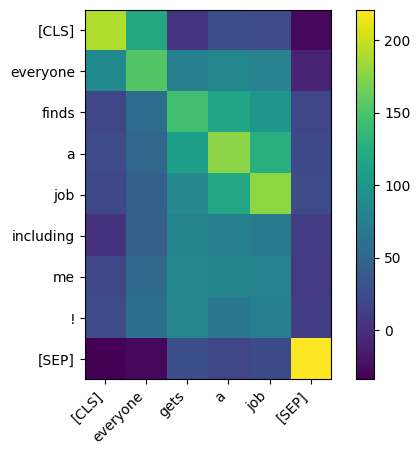

In [ ]:
x_token_labels = tokenizer.convert_ids_to_tokens(x_ids)
y_token_labels = tokenizer.convert_ids_to_tokens(y_ids)
plt.imshow(result_matrix)
plt.colorbar()
plt.xticks(range(len(y_token_labels)), y_token_labels, rotation=45, ha="right")
plt.yticks(range(len(x_token_labels)), x_token_labels)
plt.show()

### Cross-Interaction Optimization

In [ ]:
torch.einsum("xi,yj->xyij", x_embeddings[0], y_embeddings[0]).shape

torch.Size([9, 6, 768, 768])

In [ ]:
torch.matmul(x_embeddings[0].unsqueeze(1).unsqueeze(3), y_embeddings[0].unsqueeze(0).unsqueeze(2)).shape

torch.Size([9, 6, 768, 768])

In [ ]:
xy_embeddings = torch.concat((x_embeddings[0], y_embeddings[0]), dim=0)
xy_embeddings.shape

torch.Size([15, 768])

In [ ]:
torch.matmul(xy_embeddings, xy_embeddings.T).shape

torch.Size([15, 15])

In [ ]:
hessian(lambda x: (x @ x.T).sum(), xy_embeddings).transpose(1, 2).shape

torch.Size([15, 15, 768, 768])

In [ ]:
outer_matrix = torch.matmul(x_embeddings[0].unsqueeze(1).unsqueeze(3), y_embeddings[0].unsqueeze(0).unsqueeze(2)) # shape [x_seq_length, y_seq_length, hidden_size, hidden_size]
xy_embeddings = torch.concat((x_embeddings[0], y_embeddings[0]), dim=0) # shape [x_seq_length + y_seq_length, hidden_size]
hessian_matrix = hessian(lambda x: (x @ x.T).sum(), xy_embeddings).transpose(1, 2) # shape [x_seq_length + y_seq_length, x_seq_length + y_seq_length, hidden_size, hidden_size]
assert(torch.allclose(hessian_matrix[:x_seq_length, x_seq_length:], hessian_matrix[x_seq_length:, :x_seq_length].transpose(0, 1)))
result_matrix2 = (outer_matrix * hessian_matrix[:x_seq_length, x_seq_length:]).sum(dim=-1).sum(dim=-1)
result_matrix2.shape

torch.Size([9, 6])

In [ ]:
result_matrix / result_matrix2

tensor([[0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000],
        [0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000],
        [0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000],
        [0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000],
        [0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000],
        [0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000],
        [0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000],
        [0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000],
        [0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000]])

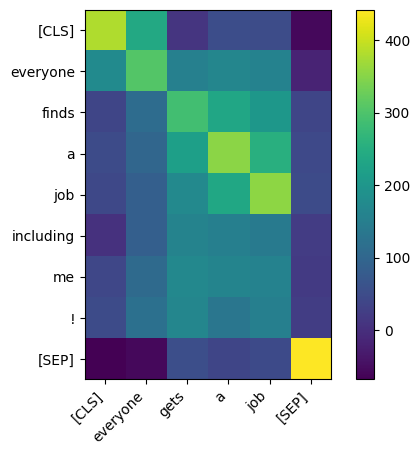

In [ ]:
x_token_labels = tokenizer.convert_ids_to_tokens(x_ids)
y_token_labels = tokenizer.convert_ids_to_tokens(y_ids)
plt.imshow(result_matrix2)
plt.colorbar()
plt.xticks(range(len(y_token_labels)), y_token_labels, rotation=45, ha="right")
plt.yticks(range(len(x_token_labels)), x_token_labels)
plt.show()